<a href="https://colab.research.google.com/github/MeEtThAkKarr/Compound-Prediction-/blob/main/Multilayered%20Perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 28.5 MB/s eta 0:00:00


In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

In [ ]:
import pandas as pd
import xlrd
# Specify the file path of your Excel file
excel_file_path = '/content/Combined_Classified_Data.xlsx'

# Specify the sheet name or index
sheet_name = 'All_Combined'  # Replace with the name of your sheet or use the index if needed (e.g., 0 for the first sheet)

# Read the specific sheet into a DataFrame
df_from_sheet = pd.read_excel(excel_file_path, sheet_name)

# Display the DataFrame
print(df_from_sheet)

### Data Cleaning

In [ ]:
columns_to_drop = [ 'Kingdom', 'Status', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Parent Level 1', 'Parent Level 2']

# Drop the specified columns
df = df_from_sheet.drop(columns=columns_to_drop, inplace = True)

# Display the DataFrame after dropping columns
print(df)

None


In [ ]:
df_from_sheet.isnull().sum()

SMILES            0
InChIKey          5
Superclass      431
Class          1422
Subclass      17175
dtype: int64

In [ ]:
df_filled = df_from_sheet.fillna(0)

# Display the DataFrame after replacing NaN values
print(df_filled)

                                                   SMILES  \
0                                     CCC(C)C[N+](=O)[O-]   
1                                     CC(C)CC[N+](=O)[O-]   
2                                                 CC#CC#C   
3                                           CCCCCCCCCCC#C   
4                                                  C#CC#C   
...                                                   ...   
107973  CC[C@H]1C[C@H]2C[C@@H]3[C@H]1N(C2)CCC4=C3NC5=C...   
107974  CC[C@H]1C[C@H]2C[C@@H]3[C@H]1N(C2)CCC4=C3NC5=C...   
107975  C[C@]12CC[C@@H](C(C1CC[C@@]3([C@@H]2CC=C4[C@]3...   
107976  CCCCOC(=O)[C@@H]1[C@H]([C@@H]([C@H]([C@@H](O1)...   
107977  CCCCOC(=O)[C@@H]1[C@H]([C@@H]([C@H]([C@@H](O1)...   

                           InChIKey                       Superclass  \
0       NAURQXSCQKYEIC-UHFFFAOYSA-N    Organic 1,3-dipolar compounds   
1       FEJLPMVSVDSKHJ-UHFFFAOYSA-N    Organic 1,3-dipolar compounds   
2       VNMDYSSJFJFEQI-UHFFFAOYSA-N                

### Feature Extraction

In [ ]:
def morgan_fpts(data, fingerprint_length=1024):
    Morgan_fpts = []
    for i in data:
        mol = Chem.MolFromSmiles(i)
        if mol is not None:
            fpts = AllChem.GetMorganFingerprintAsBitVect(mol, 2, fingerprint_length)
            mfpts = np.array(list(fpts.ToBitString())).astype(np.uint8)  # Convert to numpy array
            Morgan_fpts.append(mfpts)
        else:
            # Handle invalid SMILES strings
            Morgan_fpts.append(np.zeros(fingerprint_length, dtype=np.uint8))  # Pad with zeros
    return Morgan_fpts

Morgan_fpts = morgan_fpts(df_filled['SMILES'].values)

[06:02:32] WARNING: not removing hydrogen atom without neighbors
[06:02:37] WARNING: not removing hydrogen atom without neighbors
[06:02:49] WARNING: not removing hydrogen atom without neighbors
[06:02:59] WARNING: not removing hydrogen atom without neighbors
[06:02:59] WARNING: not removing hydrogen atom without neighbors
[06:03:05] WARNING: not removing hydrogen atom without neighbors
[06:03:07] WARNING: not removing hydrogen atom without neighbors
[06:03:08] WARNING: not removing hydrogen atom without neighbors
[06:03:08] WARNING: not removing hydrogen atom without neighbors
[06:03:08] WARNING: not removing hydrogen atom without neighbors
[06:03:09] Explicit valence for atom # 1 N, 4, is greater than permitted
[06:03:10] Explicit valence for atom # 5 N, 5, is greater than permitted
[06:03:13] Explicit valence for atom # 22 N, 4, is greater than permitted
[06:03:14] Explicit valence for atom # 1 N, 4, is greater than permitted
[06:03:15] Explicit valence for atom # 21 N, 4, is greate

In [ ]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 11.3 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2024.1-cp310-cp310-linux_x86_64.whl size=661204 sha256=530f9abd0f40d143669ad40fe86b6b091cb5bd9dfebebc08ec04d949b46127c7
  Stored in directory: /root/.cache/pip/wheels/12/34/d2/9a349255a4eca3a486d82c79d21e138ce2ccd90f414d9d72b8
Successfully built pycuda


In [ ]:
import pycuda.driver as cuda
import pycuda.autoinit  # Initialize CUDA context
Morgan_fpts_gpu = [cuda.mem_alloc(fpt.nbytes) for fpt in Morgan_fpts]
for i, fpt in enumerate(Morgan_fpts):
    cuda.memcpy_htod(Morgan_fpts_gpu[i], fpt)

# Create DataFrame on GPU
data_gpu = np.zeros((len(Morgan_fpts_gpu), 1024), dtype=np.uint8)
for i, fpt_gpu in enumerate(Morgan_fpts_gpu):
    cuda.memcpy_dtoh(data_gpu[i], fpt_gpu)

Morgan_fingerprints_gpu = pd.DataFrame(data_gpu, columns=[f'Col_{i}' for i in range(1024)])


In [ ]:
updated_df = pd.concat([Morgan_fingerprints_gpu, df_filled], axis=1)

In [ ]:
updated_df.head()


Col_0  Col_1  Col_2  Col_3  Col_4  Col_5  Col_6  Col_7  Col_8  Col_9  ...  \
0      0      1      0      0      0      0      0      0      0      0  ...   
1      0      1      0      0      0      0      0      0      0      0  ...   
2      0      0      0      0      0      0      0      0      0      0  ...   
3      0      0      0      0      0      0      0      0      0      0  ...   
4      0      0      0      0      0      0      0      0      0      0  ...   

   Col_1019  Col_1020  Col_1021  Col_1022  Col_1023               SMILES  \
0         0         0         0         0         0  CCC(C)C[N+](=O)[O-]   
1         0         0         0         0         0  CC(C)CC[N+](=O)[O-]   
2         0         1         0         0         0              CC#CC#C   
3         0         0         0         0         0        CCCCCCCCCCC#C   
4         0         0         0         0         0               C#CC#C   

                      InChIKey                     Superclass  \
0  NAURQXSCQKYEIC-UHFFFAOYSA-N  Organic 1,3-dipolar compounds   
1  FEJLPMVSVDSKHJ-UHFFFAOYSA-N  Organic 1,3-dipolar compounds   
2  VNMDYSSJFJFEQI-UHFFFAOYSA-N                     Acetylides   
3  ZVDBUOGYYYNMQI-UHFFFAOYSA-N                     Acetylides   
4  LLCSWKVOHICRDD-UHFFFAOYSA-N                     Acetylides   

                                      Class                 Subclass  
0  Allyl-type 1,3-dipolar organic compounds  Organic nitro compounds  
1  Allyl-type 1,3-dipolar organic compounds  Organic nitro compounds  
2                                         0                        0  
3                                         0                        0  
4                                         0                        0  

[5 rows x 1029 columns]

In [ ]:
new_column_names = ['Superclass_labels', 'Class_labels', 'Subclass_labels']  # Example new column names
new_column_values = [None, None, None]# Example empty values (NaN and None)
for col_name, col_value in zip(new_column_names, new_column_values):
    updated_df[col_name] = col_value

insert_index = 28  # For example, insert at index 2 (after the second column)

# Insert new columns into the DataFrame at the specified index
for col_name, col_value in zip(new_column_names, new_column_values):
    if col_name not in updated_df.columns:  # Check if the column name already exists
        updated_df.insert(insert_index, col_name, col_value)

updated_df

Col_0  Col_1  Col_2  Col_3  Col_4  Col_5  Col_6  Col_7  Col_8  Col_9  \
0           0      1      0      0      0      0      0      0      0      0   
1           0      1      0      0      0      0      0      0      0      0   
2           0      0      0      0      0      0      0      0      0      0   
3           0      0      0      0      0      0      0      0      0      0   
4           0      0      0      0      0      0      0      0      0      0   
...       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
107973      0      0      0      1      0      0      0      0      0      0   
107974      0      0      0      1      0      0      0      0      0      0   
107975      0      0      0      0      0      0      0      0      0      0   
107976      0      0      0      0      0      0      0      0      0      0   
107977      0      1      0      0      0      0      0      0      0      0   

        ...  Col_1022  Col_1023  \
0       ...         0         0   
1       ...         0         0   
2       ...         0         0   
3       ...         0         0   
4       ...         0         0   
...     ...       ...       ...   
107973  ...         0         0   
107974  ...         0         0   
107975  ...         0         0   
107976  ...         0         0   
107977  ...         0         0   

                                                   SMILES  \
0                                     CCC(C)C[N+](=O)[O-]   
1                                     CC(C)CC[N+](=O)[O-]   
2                                                 CC#CC#C   
3                                           CCCCCCCCCCC#C   
4                                                  C#CC#C   
...                                                   ...   
107973  CC[C@H]1C[C@H]2C[C@@H]3[C@H]1N(C2)CCC4=C3NC5=C...   
107974  CC[C@H]1C[C@H]2C[C@@H]3[C@H]1N(C2)CCC4=C3NC5=C...   
107975  C[C@]12CC[C@@H](C(C1CC[C@@]3([C@@H]2CC=C4[C@]3...   
107976  CCCCOC(=O)[C@@H]1[C@H]([C@@H]([C@H]([C@@H](O1)...   
107977  CCCCOC(=O)[C@@H]1[C@H]([C@@H]([C@H]([C@@H](O1)...   

                           InChIKey                       Superclass  \
0       NAURQXSCQKYEIC-UHFFFAOYSA-N    Organic 1,3-dipolar compounds   
1       FEJLPMVSVDSKHJ-UHFFFAOYSA-N    Organic 1,3-dipolar compounds   
2       VNMDYSSJFJFEQI-UHFFFAOYSA-N                       Acetylides   
3       ZVDBUOGYYYNMQI-UHFFFAOYSA-N                       Acetylides   
4       LLCSWKVOHICRDD-UHFFFAOYSA-N                       Acetylides   
...                             ...                              ...   
107973  LOPRZRPYZZZEJR-HQPKZWAQSA-N        Alkaloids and derivatives   
107974  FEQZUIYQDAAUOE-UMXRBDIUSA-N        Alkaloids and derivatives   
107975  HAKHPDLODDSOTK-XWMBHQINSA-N  Lipids and lipid-like molecules   
107976  KEDJBUGHODJQAX-JCHISVDESA-N  Lipids and lipid-like molecules   
107977  NRJDYTBXPQINHA-MPKWBJNVSA-N  Lipids and lipid-like molecules   

                                           Class                 Subclass  \
0       Allyl-type 1,3-dipolar organic compounds  Organic nitro compounds   
1       Allyl-type 1,3-dipolar organic compounds  Organic nitro compounds   
2                                              0                        0   
3                                              0                        0   
4                                              0                        0   
...                                          ...                      ...   
107973                     Ibogan-type alkaloids                        0   
107974                     Ibogan-type alkaloids                        0   
107975                             Prenol lipids       Terpene glycosides   
107976                             Prenol lipids       Terpene glycosides   
107977                             Prenol lipids       Terpene glycosides   

        Superclass_labels  Class_labels  Subclass_labels  
0                    None          None     

### Label Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Assuming df is your DataFrame and 'Superclass' is the column containing superclass labels
updated_df['Superclass'] = updated_df['Superclass'].astype(str)
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the superclass labels
encoded_labels = label_encoder.fit_transform(updated_df['Superclass'])
updated_df['Superclass_labels'] = encoded_labels

# Print the mapping of original labels to encoded labels
original_labels = label_encoder.classes_
encoded_labels = label_encoder.transform(label_encoder.classes_)

for original_label, encoded_label in zip(original_labels, encoded_labels):
    print(f"{encoded_label}: '{original_label}',")

0: '0',
1: 'Acetylides',
2: 'Alkaloids and derivatives',
3: 'Allenes',
4: 'Benzenoids',
5: 'Hydrocarbon derivatives',
6: 'Hydrocarbons',
7: 'Lignans, neolignans and related compounds',
8: 'Lipids and lipid-like molecules',
9: 'Nucleosides, nucleotides, and analogues',
10: 'Organic 1,3-dipolar compounds',
11: 'Organic Polymers',
12: 'Organic acids and derivatives',
13: 'Organic compounds',
14: 'Organic nitrogen compounds',
15: 'Organic oxygen compounds',
16: 'Organic salts',
17: 'Organohalogen compounds',
18: 'Organoheterocyclic compounds',
19: 'Organometallic compounds',
20: 'Organophosphorus compounds',
21: 'Organosulfur compounds',
22: 'Phenylpropanoids and polyketides',


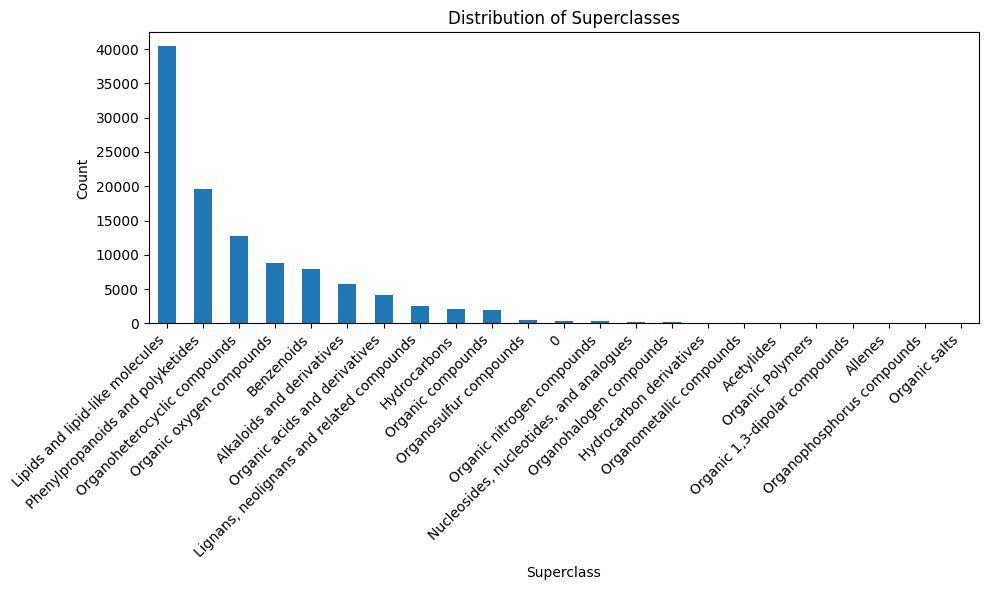

In [ ]:
import matplotlib.pyplot as plt

# Count the occurrences of each superclass
superclass_counts = updated_df['Superclass'].value_counts()

# Plot the bar graph
plt.figure(figsize=(10, 6))
superclass_counts.plot(kind='bar')
plt.title('Distribution of Superclasses')
plt.xlabel('Superclass')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


In [ ]:
from sklearn.preprocessing import LabelEncoder

updated_df['Class'] = updated_df['Class'].astype(str)
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'Class' column
updated_df['Class_labels'] = label_encoder.fit_transform(updated_df['Class'])

# Print the mapping of original labels to encoded labels
original_labels = label_encoder.classes_
encoded_labels = label_encoder.transform(label_encoder.classes_)

for original_label, encoded_label in zip(original_labels, encoded_labels):
    print(f"{encoded_label}: '{original_label}',")



0: '(3'->5')-dinucleotides and analogues',
1: '(5'->5')-dinucleotides',
2: '0',
3: '1-azaoxoaporphines',
4: '2-arylbenzofuran flavonoids',
5: '3,4-dihydrocoumarins',
6: '5'-deoxyribonucleosides',
7: '6,6a-secoaporphines',
8: '6,7-benzomorphans',
9: '9b-azaphenalenes',
10: 'Acenaphthylenes',
11: 'Acetylides',
12: 'Acutumine and related alkaloids',
13: 'Acyclic allenes',
14: 'Acyl halides',
15: 'Ajmaline-sarpagine alkaloids',
16: 'Akageran and related alkaloids',
17: 'Akuammilan and related alkaloids',
18: 'Alkaloids and derivatives',
19: 'Alkyl halides',
20: 'Alkylhalophosphines',
21: 'Allocolchicine alkaloids',
22: 'Allyl sulfur compounds',
23: 'Allyl-type 1,3-dipolar organic compounds',
24: 'Alpha-methyldeoxybenzoin flavonoids',
25: 'Amaryllidaceae alkaloids',
26: 'Angucyclines',
27: 'Anthracenes',
28: 'Anthracyclines',
29: 'Aporphines',
30: 'Aristolactams',
31: 'Aromatic hydrocarbons',
32: 'Aryl halides',
33: 'Arylnaphthalene lignans',
34: 'Aryltetralin lignans',
35: 'Aspidofractine 

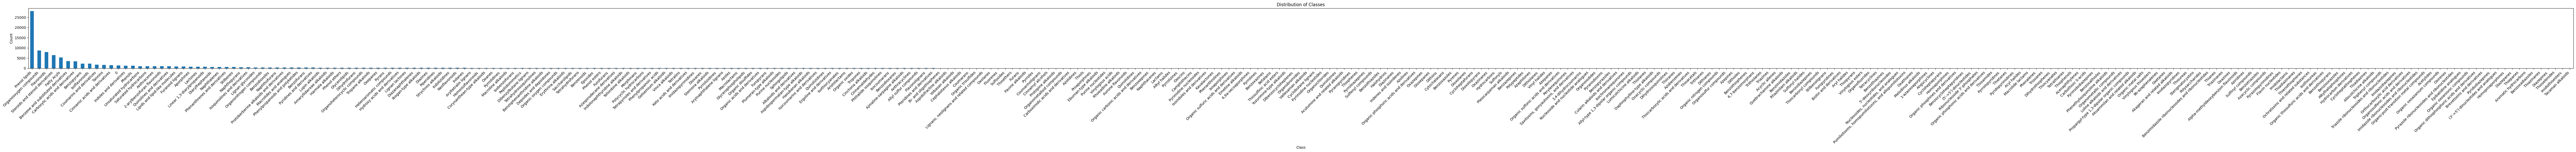

In [ ]:
import matplotlib.pyplot as plt

# Count the occurrences of each superclass
superclass_counts = updated_df['Class'].value_counts()

# Plot the bar graph
plt.figure(figsize=(100, 6))
superclass_counts.plot(kind='bar')
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


In [ ]:
from sklearn.preprocessing import LabelEncoder

updated_df['Subclass'] = updated_df['Subclass'].astype(str)
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'Class' column
updated_df['Subclass_labels'] = label_encoder.fit_transform(updated_df['Subclass'])

# Print the mapping of original labels to encoded labels
original_labels = label_encoder.classes_
encoded_labels = label_encoder.transform(label_encoder.classes_)

for original_label, encoded_label in zip(original_labels, encoded_labels):
    print(f"{encoded_label}: '{original_label}',")

0: '(3'->5')-dinucleotides',
1: '0',
2: '1,1'-azonaphthalenes',
3: '1,2-diazepines',
4: '1,2-dioxanes',
5: '1,2-dioxolanes',
6: '1,2-dithiolanes',
7: '1,2-dithioles',
8: '1,2-oxazinanes',
9: '1,3,5-triazinanes',
10: '1,3,5-triazines',
11: '1,3-dioxanes',
12: '1,3-dioxepanes',
13: '1,3-dioxolanes',
14: '1,3-dithiolanes',
15: '1,4-benzodiazepines',
16: '1,4-diazepanes',
17: '1,4-dioxanes',
18: '1,4-dioxepanes',
19: '1,4-isoquinolinediones',
20: '1,4-oxazepines',
21: '1,4-oxazines',
22: '1-benzopyrans',
23: '1-benzothiophenes',
24: '1-benzothiopyrans',
25: '1-hydroxy-2-unsubstituted benzenoids',
26: '1-hydroxy-4-unsubstituted benzenoids',
27: '1-phenylcoumarans',
28: '1-phenyltetrahydroisoquinolines',
29: '1-pyranosylindoles',
30: '1-ribosyl-imidazolecarboxamides',
31: '17-furanylsteroids and derivatives',
32: '2,3,5-trisubstituted thiophenes',
33: '2,5-disubstituted thiophenes',
34: '2,6-dimethyl-3-benzazocines',
35: '2-arylbenzofuran flavonoids',
36: '2-benzimidazolylcarbamic acid ester

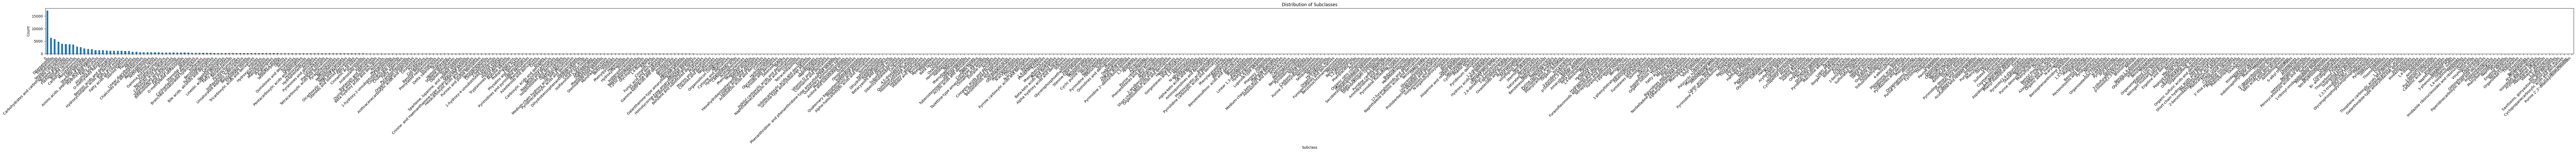

In [ ]:
import matplotlib.pyplot as plt

# Count the occurrences of each superclass
superclass_counts = updated_df['Subclass'].value_counts()

# Plot the bar graph
plt.figure(figsize=(100, 6))
superclass_counts.plot(kind='bar')
plt.title('Distribution of Subclasses')
plt.xlabel('Subclass')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


#### MODEL

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from rdkit import Chem
from rdkit.Chem import AllChem

In [ ]:
# Convert Morgan fingerprints to numpy array
morgan_fingerprints = updated_df.loc[:, 'Col_0':'Col_1023'].values.astype(float)  # Convert to float

In [ ]:
# Convert superclass, class, and subclass to numpy arrays
superclass_labels = updated_df['Superclass_labels'].values.astype(int)
class_labels = updated_df['Class_labels'].values.astype(int)
subclass_labels = updated_df['Subclass_labels'].values.astype(int)

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train_superclass, y_test_superclass, y_train_class, y_test_class, y_train_subclass, y_test_subclass = train_test_split(
    morgan_fingerprints, superclass_labels, class_labels, subclass_labels, test_size=0.2, random_state=42)

In [ ]:
# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_superclass_tensor = torch.tensor(y_train_superclass, dtype=torch.long)
y_train_class_tensor = torch.tensor(y_train_class, dtype=torch.long)
y_train_subclass_tensor = torch.tensor(y_train_subclass, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_superclass_tensor = torch.tensor(y_test_superclass, dtype=torch.long)
y_test_class_tensor = torch.tensor(y_test_class, dtype=torch.long)
y_test_subclass_tensor = torch.tensor(y_test_subclass, dtype=torch.long)

In [ ]:
# Create DataLoader for training and testing sets
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_superclass_tensor, y_train_class_tensor, y_train_subclass_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_superclass_tensor, y_test_class_tensor, y_test_subclass_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define the neural network model
class MulticlassModel(nn.Module):
    def __init__(self, input_size, superclass_output_size, class_output_size, subclass_output_size):
        super(MulticlassModel, self).__init__()
        self.layer_1 = nn.Linear(input_size, 512)
        self.layer_2 = nn.Linear(512, 256)
        self.layer_superclass = nn.Linear(256, superclass_output_size)
        self.layer_class = nn.Linear(256, class_output_size)
        self.layer_subclass = nn.Linear(256, subclass_output_size)

    def forward(self, x):
        x = torch.relu(self.layer_1(x))
        x = torch.relu(self.layer_2(x))
        superclass_output = self.layer_superclass(x)
        class_output = self.layer_class(x)
        subclass_output = self.layer_subclass(x)
        return superclass_output, class_output, subclass_output

In [ ]:
# Instantiate the model and send it to the target device
input_size = morgan_fingerprints.shape[1]
superclass_output_size = len(np.unique(superclass_labels))
class_output_size = len(np.unique(class_labels))
subclass_output_size = len(np.unique(subclass_labels))
model = MulticlassModel(input_size, superclass_output_size, class_output_size, subclass_output_size)

In [ ]:
# Define loss function, optimizer, and learning rate
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training the model on GPU
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y_superclass, batch_y_class, batch_y_subclass in train_loader:
        # Move data to GPU
        batch_X = batch_X
        batch_y_superclass = batch_y_superclass
        batch_y_class = batch_y_class
        batch_y_subclass = batch_y_subclass

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        superclass_output, class_output, subclass_output = model(batch_X)

        # Compute loss
        loss_superclass = criterion(superclass_output, batch_y_superclass)
        loss_class = criterion(class_output, batch_y_class)
        loss_subclass = criterion(subclass_output, batch_y_subclass)
        loss = loss_superclass + loss_class + loss_subclass

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

    # Print training loss after each epoch
    print(f'Epoch {epoch + 1}/{num_epochs}, Total Loss: {loss.item()}')


Epoch 1/10, Total Loss: 1.821696162223816
Epoch 2/10, Total Loss: 2.272777557373047
Epoch 3/10, Total Loss: 0.36198604106903076
Epoch 4/10, Total Loss: 0.8648995757102966
Epoch 5/10, Total Loss: 1.173333764076233
Epoch 6/10, Total Loss: 0.35451287031173706
Epoch 7/10, Total Loss: 1.237450361251831
Epoch 8/10, Total Loss: 1.2821149826049805
Epoch 9/10, Total Loss: 0.40497392416000366
Epoch 10/10, Total Loss: 0.62193763256073


Test Accuracy - Superclass: 92.37%
Test Accuracy - Class: 90.30%
Test Accuracy - Subclass: 88.59%


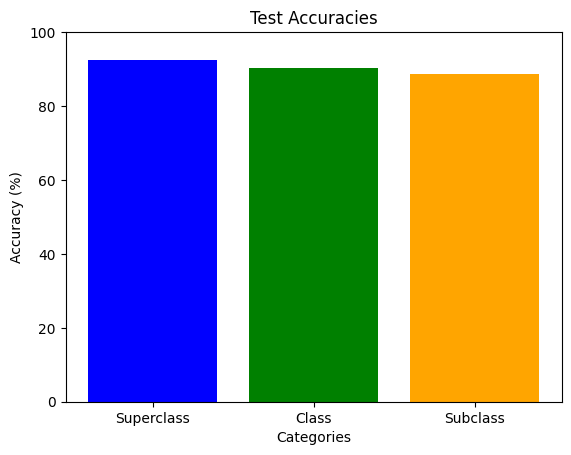

In [ ]:
import matplotlib.pyplot as plt

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    correct_superclass = 0
    correct_class = 0
    correct_subclass = 0
    total = 0
    for batch_X, batch_y_superclass, batch_y_class, batch_y_subclass in test_loader:
        superclass_output, class_output, subclass_output = model(batch_X)
        _, predicted_superclass = torch.max(superclass_output, 1)
        _, predicted_class = torch.max(class_output, 1)
        _, predicted_subclass = torch.max(subclass_output, 1)
        total += batch_y_superclass.size(0)
        correct_superclass += (predicted_superclass == batch_y_superclass).sum().item()
        correct_class += (predicted_class == batch_y_class).sum().item()
        correct_subclass += (predicted_subclass == batch_y_subclass).sum().item()

    accuracy_superclass = correct_superclass / total * 100
    accuracy_class = correct_class / total * 100
    accuracy_subclass = correct_subclass / total * 100
    print(f'Test Accuracy - Superclass: {accuracy_superclass:.2f}%')
    print(f'Test Accuracy - Class: {accuracy_class:.2f}%')
    print(f'Test Accuracy - Subclass: {accuracy_subclass:.2f}%')

# Plot the test accuracies
categories = ['Superclass', 'Class', 'Subclass']
accuracies = [accuracy_superclass, accuracy_class, accuracy_subclass]

plt.bar(categories, accuracies, color=['blue', 'green', 'orange'])
plt.xlabel('Categories')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracies')
plt.ylim(0, 100)  # Set y-axis limit from 0 to 100
plt.show()


## **Dictionaries**

In [ ]:
### Adding Dictionaries for labels
Superclass_mapping = {0: '0',
1: 'Acetylides',
2: 'Alkaloids and derivatives',
3: 'Allenes',
4: 'Benzenoids',
5: 'Hydrocarbon derivatives',
6: 'Hydrocarbons',
7: 'Lignans, neolignans and related compounds',
8: 'Lipids and lipid-like molecules',
9: 'Nucleosides, nucleotides, and analogues',
10: 'Organic 1,3-dipolar compounds',
11: 'Organic Polymers',
12: 'Organic acids and derivatives',
13: 'Organic compounds',
14: 'Organic nitrogen compounds',
15: 'Organic oxygen compounds',
16: 'Organic salts',
17: 'Organohalogen compounds',
18: 'Organoheterocyclic compounds',
19: 'Organometallic compounds',
20: 'Organophosphorus compounds',
21: 'Organosulfur compounds',
22: 'Phenylpropanoids and polyketides'
}

Class_mapping = {
0: '(3->5)-dinucleotides and analogues',
1: '(5->5)-dinucleotides',
2: '0',
3: '1-azaoxoaporphines',
4: '2-arylbenzofuran flavonoids',
5: '3,4-dihydrocoumarins',
6: '5-deoxyribonucleosides',
7: '6,6a-secoaporphines',
8: '6,7-benzomorphans',
9: '9b-azaphenalenes',
10: 'Acenaphthylenes',
11: 'Acetylides',
12: 'Acutumine and related alkaloids',
13: 'Acyclic allenes',
14: 'Acyl halides',
15: 'Ajmaline-sarpagine alkaloids',
16: 'Akageran and related alkaloids',
17: 'Akuammilan and related alkaloids',
18: 'Alkaloids and derivatives',
19: 'Alkyl halides',
20: 'Alkylhalophosphines',
21: 'Allocolchicine alkaloids',
22: 'Allyl sulfur compounds',
23: 'Allyl-type 1,3-dipolar organic compounds',
24: 'Alpha-methyldeoxybenzoin flavonoids',
25: 'Amaryllidaceae alkaloids',
26: 'Angucyclines',
27: 'Anthracenes',
28: 'Anthracyclines',
29: 'Aporphines',
30: 'Aristolactams',
31: 'Aromatic hydrocarbons',
32: 'Aryl halides',
33: 'Arylnaphthalene lignans',
34: 'Aryltetralin lignans',
35: 'Aspidofractine alkaloids',
36: 'Aspidospermatan-type alkaloids',
37: 'Aurone flavonoids',
38: 'Azacyclic compounds',
39: 'Azaphilones',
40: 'Azaspirodecane derivatives',
41: 'Azepanes',
42: 'Azepines',
43: 'Aziridines',
44: 'Azobenzenes',
45: 'Azoles',
46: 'Azolidines',
47: 'Azolines',
48: 'Benzazepines',
49: 'Benzene and substituted derivatives',
50: 'Benzenoids',
51: 'Benzimidazole ribonucleosides and ribonucleotides',
52: 'Benzimidazoles',
53: 'Benzisoxazoles',
54: 'Benzocycloheptapyridines',
55: 'Benzodiazepines',
56: 'Benzodioxanes',
57: 'Benzodioxoles',
58: 'Benzofurans',
59: 'Benzophenanthridine alkaloids',
60: 'Benzopyrans',
61: 'Benzopyrazoles',
62: 'Benzothiazines',
63: 'Benzothiazoles',
64: 'Benzothiophenes',
65: 'Benzothiopyrans',
66: 'Benzotriazoles',
67: 'Benzoxadiazoles',
68: 'Benzoxathioles',
69: 'Benzoxazines',
70: 'Benzoxazoles',
71: 'Benzoxepines',
72: 'Betalains',
73: 'Bi- and oligothiophenes',
74: 'Biotin and derivatives',
75: 'Brevetoxins and derivatives',
76: 'Camptothecins',
77: 'Carbothioic S-acids',
78: 'Carboximidic acids and derivatives',
79: 'Carboxylic acids and derivatives',
80: 'Cephalotaxus alkaloids',
81: 'Cinchona alkaloids',
82: 'Cinnamaldehydes',
83: 'Cinnamic acids and derivatives',
84: 'Cinnamyl alcohols',
85: 'Corynanthean-type alkaloids',
86: 'Coumarans',
87: 'Coumarinolignans',
88: 'Coumarins and derivatives',
89: 'Cularin alkaloids and derivatives',
90: 'Cyclobutane lignans',
91: 'Cycloheptafurans',
92: 'Cycloheptapyrans',
93: 'Cycloheptathiophenes',
94: 'Cytochalasans',
95: 'Daphniphylline-type alkaloids',
96: 'Depsides and depsidones',
97: 'Diarylheptanoids',
98: 'Diazanaphthalenes',
99: 'Diazepanes',
100: 'Diazepines',
101: 'Diazinanes',
102: 'Diazines',
103: 'Dibenzocycloheptenes',
104: 'Dibenzylbutane lignans',
105: 'Dihydrofurans',
106: 'Dihydroisoquinolines',
107: 'Dihydrothiophenes',
108: 'Dioxanes',
109: 'Dioxepanes',
110: 'Dioxolanes',
111: 'Dioxolopyrans',
112: 'Dithianes',
113: 'Dithiins',
114: 'Dithiolanes',
115: 'Dithioles',
116: 'Eburnan-type alkaloids',
117: 'Emetine alkaloids',
118: 'Epibatidine analogues',
119: 'Epoxides',
120: 'Ergoline and derivatives',
121: 'Erythrina alkaloids',
122: 'Fatty Acyls',
123: 'Flavin nucleotides',
124: 'Flavonoids',
125: 'Flavonolignans',
126: 'Fluorenes',
127: 'Furanoid lignans',
128: 'Furans',
129: 'Furofurans',
130: 'Furopyrans',
131: 'Furopyridines',
132: 'Gelsemium alkaloids',
133: 'Glycerolipids',
134: 'Glycerophospholipids',
135: 'Halohydrins',
136: 'Harmala alkaloids',
137: 'Hasubanan alkaloids',
138: 'Heteroaromatic compounds',
139: 'Homoaporphines',
140: 'Homoisoflavonoids',
141: 'Homoproaporphines',
142: 'Hydrocarbon derivatives',
143: 'Hydrocarbons',
144: 'Hydroxy acids and derivatives',
145: 'Ibogan-type alkaloids',
146: 'Imidazodiazepines',
147: 'Imidazole ribonucleosides and ribonucleotides',
148: 'Imidazopyridines',
149: 'Imidazopyrimidines',
150: 'Imidolactams',
151: 'Imidothioesters',
152: 'Indanes',
153: 'Indenes and isoindenes',
154: 'Indoles and derivatives',
155: 'Indolizidines',
156: 'Indolonaphthyridine alkaloids',
157: 'Isoaporphines',
158: 'Isobenzofurans',
159: 'Isochromanequinones',
160: 'Isocoumarans',
161: 'Isocoumarins and derivatives',
162: 'Isoflavonoids',
163: 'Isoindoles and derivatives',
164: 'Isoquinolines and derivatives',
165: 'Isothiocyanates',
166: 'Isothioureas',
167: 'Kavalactones',
168: 'Keto acids and derivatives',
169: 'Lactams',
170: 'Lactones',
171: 'Lignan glycosides',
172: 'Lignan lactones',
173: 'Lignans, neolignans and related compounds',
174: 'Linear 1,3-diarylpropanoids',
175: 'Lipids and lipid-like molecules',
176: 'Loline alkaloids and derivatives',
177: 'Lumicolchicine alkaloids',
178: 'Lupin alkaloids',
179: 'Macrolactams',
180: 'Macrolide lactams',
181: 'Macrolides and analogues',
182: 'Macroline alkaloids',
183: 'Melodinus alkaloids',
184: 'Morphinans',
185: 'Naphthacenes',
186: 'Naphthalenes',
187: 'Naphthofurans',
188: 'Naphthopyrans',
189: 'Neoflavonoids',
190: 'Nucleoside and nucleotide analogues',
191: 'Nucleosides, nucleotides, and analogues',
192: 'Ochratoxins and related substances',
193: 'Organic acids and derivatives',
194: 'Organic carbonic acids and derivatives',
195: 'Organic disulfides',
196: 'Organic dithiophosphoric acids and derivatives',
197: 'Organic metal salts',
198: 'Organic nitrogen compounds',
199: 'Organic oxides',
200: 'Organic oxoanionic compounds',
201: 'Organic oxoazanium compounds',
202: 'Organic oxygen compounds',
203: 'Organic phosphines and derivatives',
204: 'Organic phosphonic acids and derivatives',
205: 'Organic phosphoric acids and derivatives',
206: 'Organic sulfonic acids and derivatives',
207: 'Organic sulfuric acids and derivatives',
208: 'Organic thiosulfuric acids and derivatives',
209: 'Organic trisulfides',
210: 'Organo-post-transition metal compounds',
211: 'Organobromides',
212: 'Organochlorides',
213: 'Organofluorides',
214: 'Organoheterocyclic compounds',
215: 'Organoiodides',
216: 'Organometallic compounds',
217: 'Organometalloid compounds',
218: 'Organonitrogen compounds',
219: 'Organooxygen compounds',
220: 'Organosulfenic acids and derivatives',
221: 'Organosulfur compounds',
222: 'Orthocarboxylic acid derivatives',
223: 'Oxacyclic compounds',
224: 'Oxanes',
225: 'Oxathianes',
226: 'Oxazepines',
227: 'Oxazinanes',
228: 'Oxazines',
229: 'Oxepanes',
230: 'Oxetanes',
231: 'Oxirenes',
232: 'Oxocins',
233: 'Oxolanes',
234: 'Pavine alkaloids',
235: 'Peptidomimetics',
236: 'Perylenequinones',
237: 'Phenalenes',
238: 'Phenanthrenes and derivatives',
239: 'Phenanthrolines',
240: 'Phenethylisoquinoline alkaloids',
241: 'Phenol esters',
242: 'Phenol ethers',
243: 'Phenols',
244: 'Phenylpropanoic acids',
245: 'Phenylpropanoids and polyketides',
246: 'Phthalide isoquinolines',
247: 'Piperidines',
248: 'Pleiocarpaman alkaloids',
249: 'Plumeran-type alkaloids',
250: 'Polycyclic hydrocarbons',
251: 'Polypeptides',
252: 'Polysaccharides',
253: 'Prenol lipids',
254: 'Proaporphines',
255: 'Propargyl-type 1,3-dipolar organic compounds',
256: 'Protoberberine alkaloids and derivatives',
257: 'Protopine alkaloids',
258: 'Pteridines and derivatives',
259: 'Pumiliotoxins, homopumiliotoxins, and allopumiliotoxins',
260: 'Purine nucleosides',
261: 'Purine nucleotides',
262: 'Pyranodioxins',
263: 'Pyranopyridines',
264: 'Pyrans',
265: 'Pyrazole ribonucleosides and ribonucleotides',
266: 'Pyrazolopyrimidines',
267: 'Pyrenes',
268: 'Pyridines and derivatives',
269: 'Pyridodiazepines',
270: 'Pyridopyrimidines',
271: 'Pyrimidine nucleosides',
272: 'Pyrimidine nucleotides',
273: 'Pyrimidodiazepines',
274: 'Pyrroles',
275: 'Pyrrolidines',
276: 'Pyrrolines',
277: 'Pyrrolizidines',
278: 'Pyrrolizines',
279: 'Pyrroloazepines',
280: 'Pyrrolopyridines',
281: 'Quebrachamine alkaloids',
282: 'Quinolidines',
283: 'Quinolines and derivatives',
284: 'Quinolizidines',
285: 'Quinolizines',
286: 'Rhazinilam alkaloids',
287: 'Rhoeadine alkaloids',
288: 'Ribonucleoside 3-phosphates',
289: 'Saccharolipids',
290: 'Saturated hydrocarbons',
291: 'Saxitoxins, gonyautoxins, and derivatives',
292: 'Sphingolipids',
293: 'Stemona alkaloids',
294: 'Sterigmatocystins',
295: 'Steroids and steroid derivatives',
296: 'Stilbenes',
297: 'Stilbenolignans',
298: 'Strychnos alkaloids',
299: 'Sulfenyl compounds',
300: 'Sulfinyl compounds',
301: 'Sulfonyl halides',
302: 'Sulfonyls',
303: 'Sulfoxides',
304: 'Tacaman alkaloids',
305: 'Tannins',
306: 'Tetracyclines',
307: 'Tetrahydrofurans',
308: 'Tetrahydroisoquinolines',
309: 'Tetralins',
310: 'Tetrapyrroles and derivatives',
311: 'Tetrathianes',
312: 'Thiadiazinanes',
313: 'Thiadiazines',
314: 'Thianes',
315: 'Thiazinanes',
316: 'Thienothiophenes',
317: 'Thiepanes',
318: 'Thietanes',
319: 'Thiiranes',
320: 'Thioacetals',
321: 'Thioamides',
322: 'Thiocarbonyl compounds',
323: 'Thiocarboxylic acids and derivatives',
324: 'Thiocyanates',
325: 'Thioethers',
326: 'Thiolanes',
327: 'Thiols',
328: 'Thiophenes',
329: 'Thiophenols',
330: 'Thiopyrans',
331: 'Thioselenides',
332: 'Thiosulfinic acid esters',
333: 'Thioureas',
334: 'Triazinanes',
335: 'Triazines',
336: 'Triazole ribonucleosides and ribonucleotides',
337: 'Trioxanes',
338: 'Triphenyl compounds',
339: 'Trithianes',
340: 'Trithiolanes',
341: 'Tropane alkaloids',
342: 'Tropones',
343: 'Unsaturated hydrocarbons',
344: 'Vallesaman alkaloids',
345: 'Vinca alkaloids',
346: 'Vinyl halides',
347: 'Vinylogous acids',
348: 'Vinylogous esters',
349: 'Vinylogous thioesters',
350: 'Vobasan alkaloids',
351: 'Yohimbine alkaloids',
352: 'Yuzurimine-type alkaloids',
}

Subclass_mapping = {
0: '(3->5)-dinucleotides',
1: '0',
2: '1,1-azonaphthalenes',
3: '1,2-diazepines',
4: '1,2-dioxanes',
5: '1,2-dioxolanes',
6: '1,2-dithiolanes',
7: '1,2-dithioles',
8: '1,2-oxazinanes',
9: '1,3,5-triazinanes',
10: '1,3,5-triazines',
11: '1,3-dioxanes',
12: '1,3-dioxepanes',
13: '1,3-dioxolanes',
14: '1,3-dithiolanes',
15: '1,4-benzodiazepines',
16: '1,4-diazepanes',
17: '1,4-dioxanes',
18: '1,4-dioxepanes',
19: '1,4-isoquinolinediones',
20: '1,4-oxazepines',
21: '1,4-oxazines',
22: '1-benzopyrans',
23: '1-benzothiophenes',
24: '1-benzothiopyrans',
25: '1-hydroxy-2-unsubstituted benzenoids',
26: '1-hydroxy-4-unsubstituted benzenoids',
27: '1-phenylcoumarans',
28: '1-phenyltetrahydroisoquinolines',
29: '1-pyranosylindoles',
30: '1-ribosyl-imidazolecarboxamides',
31: '17-furanylsteroids and derivatives',
32: '2,3,5-trisubstituted thiophenes',
33: '2,5-disubstituted thiophenes',
34: '2,6-dimethyl-3-benzazocines',
35: '2-arylbenzofuran flavonoids',
36: '2-benzimidazolylcarbamic acid esters',
37: '2-benzopyrans',
38: '2-phenoxypropionic acids',
39: '3-thia pyrimidine nucleosides',
40: '3-phenoxypropionic acids',
41: '3-pyridinecarbonitriles',
42: '3-ribofuranosylpyrazoles',
43: '4,5-dioxoaporphines',
44: '4-alkoxyphenols',
45: '4-phenyltetrahydroisoquinolines',
46: '5-deoxy-5-thionucleosides',
47: '5-deoxyribonucleosides',
48: '8-hydroxyquinolines',
49: '9,9p-dihydroxyaryltetralin lignans',
50: 'Acetophenones',
51: 'Acetylenes',
52: 'Acrylic acids and derivatives',
53: 'Acutumine and related alkaloids',
54: 'Acyl chlorides',
55: 'Alcohols and polyols',
56: 'Alkanes',
57: 'Alkyl fluorides',
58: 'Alkylthiols',
59: 'Alloxazines and isoalloxazines',
60: 'Allyl sulfur compounds',
61: 'Aloperine and related alkaloids',
62: 'Alpha hydroxy acids and derivatives',
63: 'Alpha-halocarboxylic acids and derivatives',
64: 'Alpha-keto acids and derivatives',
65: 'Amaryllidaceae alkaloids',
66: 'Aminals',
67: 'Amines',
68: 'Amino acids, peptides, and analogues',
69: 'Aminophenyl ethers',
70: 'Aminopyridines and derivatives',
71: 'Aminoquinolines and derivatives',
72: 'Aminothiophenes',
73: 'Aminotriazines',
74: 'Aminoxides',
75: 'Anagyrine-type alkaloids',
76: 'Androstane steroids',
77: 'Anilides',
78: 'Aniline and substituted anilines',
79: 'Anisoles',
80: 'Anthocyanidins',
81: 'Anthracenecarboxylic acids and derivatives',
82: 'Anthracenes',
83: 'Anthracyclines',
84: 'Anthraquinones',
85: 'Aporphines',
86: 'Aristolactams',
87: 'Aristolochic acids and derivatives',
88: 'Aryl bromides',
89: 'Aryl chlorides',
90: 'Aryl thioethers',
91: 'Arylhydroxamates',
92: 'Arylnaphthalene lignans',
93: 'Arylsulfates',
94: 'Aryltetralin lignans',
95: 'Aspidofractine alkaloids',
96: 'Aspidospermatan-type alkaloids',
97: 'Aspochalasins',
98: 'Aurone flavonoids',
99: 'Auronols',
100: 'Azaspirodecane derivatives',
101: 'Azasteroids and derivatives',
102: 'Azoxy compounds',
103: 'Benzazocines',
104: 'Benzene and substituted derivatives',
105: 'Benzenediols',
106: 'Benzenesulfonamides',
107: 'Benzenesulfonic acids and derivatives',
108: 'Benzenesulfonyl compounds',
109: 'Benzenetriols and derivatives',
110: 'Benzisoxazolones',
111: 'Benzo-1,4-dioxanes',
112: 'Benzodiazines',
113: 'Benzodioxanes',
114: 'Benzodioxoles',
115: 'Benzofuranones',
116: 'Benzofurans',
117: 'Benzoic acids and derivatives',
118: 'Benzoins',
119: 'Benzoisochromanequinones',
120: 'Benzonitriles',
121: 'Benzophenanthridine alkaloids',
122: 'Benzophenones',
123: 'Benzopyrans',
124: 'Benzopyrazoles',
125: 'Benzopyrenes',
126: 'Benzoquinolines',
127: 'Benzothiadiazines',
128: 'Benzoxazinones',
129: 'Benzoxazolones',
130: 'Benzoyl derivatives',
131: 'Benzoyl peroxides',
132: 'Benzoylindoles',
133: 'Benzyl alcohols',
134: 'Benzyl cyanides',
135: 'Benzyl halides',
136: 'Benzyl thiocyanates',
137: 'Benzylamines',
138: 'Benzylethers',
139: 'Benzylisoquinolines',
140: 'Benzyloxycarbonyls',
141: 'Benzylpiperidines',
142: 'Beta hydroxy acids and derivatives',
143: 'Beta lactams',
144: 'Beta propiolactones',
145: 'Beta-keto acids and derivatives',
146: 'Betacyanins and derivatives',
147: 'Bi- and oligothiophenes',
148: 'Biflavonoids and polyflavonoids',
149: 'Bile acids, alcohols and derivatives',
150: 'Bilirubins',
151: 'Biphenols',
152: 'Biphenyls and derivatives',
153: 'Bipyridines and oligopyridines',
154: 'Branched unsaturated hydrocarbons',
155: 'Bromohydrins',
156: 'Butyrophenones',
157: 'Caprolactams',
158: 'Carbazoles',
159: 'Carbohydrates and carbohydrate conjugates',
160: 'Carbonic acid diesters',
161: 'Carbonic acid monoesters',
162: 'Carbonyl compounds',
163: 'Carboximidic acids',
164: 'Carboxylic acid derivatives',
165: 'Carboxylic acids',
166: 'Carboxylic acids and derivatives',
167: 'Ceramides',
168: 'Chaetoglobosins',
169: 'Chalcones and dihydrochalcones',
170: 'Chlorins',
171: 'Chlorohydrins',
172: 'Cholestane steroids',
173: 'Chrysenes',
174: 'Cinnamaldehydes',
175: 'Cinnamic acid amides',
176: 'Cinnamic acid esters',
177: 'Cinnamic acids',
178: 'Cinnamic acids and derivatives',
179: 'Cinnamyl alcohols',
180: 'Cinnamylphenols',
181: 'Clavines and derivatives',
182: 'Complex tannins',
183: 'Corrinoids',
184: 'Coumarans',
185: 'Coumarin glycosides',
186: 'Coumarinolignans',
187: 'Coumarins and derivatives',
188: 'Coumaronochromones',
189: 'Coumestans',
190: 'Cresols',
191: 'Crinine- and Haemanthamine-type amaryllidaceae alkaloids',
192: 'Cucurbitacins',
193: 'Cumenes',
194: 'Cyclic diarylheptanoids',
195: 'Cyclic purine nucleotides',
196: 'Cycloalkanes',
197: 'Cycloartanols and derivatives',
198: 'Cyclobutane lignans',
199: 'Cyclohexyl halides',
200: 'Cyclohexylamines',
201: 'Cyclohexylphenols',
202: 'Cyclopentyl nucleosides',
203: 'Cyclopropanecarboxylic acids and derivatives',
204: 'Cytisine and derivatives',
205: 'Cytochalasins',
206: 'Dalbergiones',
207: 'Delta valerolactones',
208: 'Delta-5-steroids',
209: 'Depsides and depsidones',
210: 'Depsipeptides',
211: 'Dialkyldisulfides',
212: 'Dialkylthioethers',
213: 'Diarylheptanoids',
214: 'Diazanaphthalenes',
215: 'Diazinanes',
216: 'Diazines',
217: 'Diazo compounds',
218: 'Dibenzofurans',
219: 'Dibenzothiophenes',
220: 'Dibenzoxepines',
221: 'Dibenzylbutane lignans',
222: 'Dibenzylbutanediol lignans',
223: 'Dicarboxylic acids and derivatives',
224: 'Dihydrobenzophenanthridine alkaloids',
225: 'Dihydrofuranoquinolines',
226: 'Dihydrofurans',
227: 'Dioxanes',
228: 'Dioxepanes',
229: 'Diphenylethers',
230: 'Diphenylmethanes',
231: 'Diradylglycerols',
232: 'Diterpenoids',
233: 'Dithiazinanes',
234: 'Dithioacetals',
235: 'Dithiolanecarboxylic acids',
236: 'Dithiophosphate O-esters',
237: 'Ecdysteroids',
238: 'Eicosanoids',
239: 'Emetine alkaloids',
240: 'Enediols',
241: 'Enolates',
242: 'Enols',
243: 'Enynes',
244: 'Epithionitriles',
245: 'Ergoline and derivatives',
246: 'Ergostane steroids',
247: 'Erythrina alkaloids',
248: 'Erythrinanes',
249: 'Estrane steroids',
250: 'Ethers',
251: 'Fatty Acyls',
252: 'Fatty acid esters',
253: 'Fatty acids and conjugates',
254: 'Fatty acyl glycosides',
255: 'Fatty acyl thioesters',
256: 'Fatty alcohol esters',
257: 'Fatty alcohols',
258: 'Fatty aldehydes',
259: 'Fatty amides',
260: 'Flavaglines',
261: 'Flavans',
262: 'Flavones',
263: 'Flavonoid glycosides',
264: 'Flavonoids',
265: 'Fluorenes',
266: 'Fumonisins',
267: 'Furanocoumarins',
268: 'Furanoflavonoids and dihydrofuranoflavonoids',
269: 'Furanoid lignans',
270: 'Furanoisoflavonoids',
271: 'Furanonaphthodioxoles',
272: 'Furanones',
273: 'Furanoquinolines',
274: 'Furans',
275: 'Furofurans',
276: 'Furoic acid and derivatives',
277: 'Furopyrans',
278: 'Furospirostanes and derivatives',
279: 'Furostanes and derivatives',
280: 'Galanthamine-type amaryllidaceae alkaloids',
281: 'Galanthindole-type amaryllidaceae alkaloids',
282: 'Gamma butyrolactones',
283: 'Gamma-keto acids and derivatives',
284: 'Gelsemium alkaloids',
285: 'Glycerol ethers',
286: 'Glycerol vinyl ethers',
287: 'Glycerolipids',
288: 'Glycerophosphates',
289: 'Glycerophosphocholines',
290: 'Glycerophosphoethanolamines',
291: 'Glycerophosphoglycerols',
292: 'Glycerophosphoglycerophosphoglycerols',
293: 'Glycerophosphoinositols',
294: 'Glycerophosphoserines',
295: 'Glycosphingolipids',
296: 'Glycosylglycerols',
297: 'Gorgostanes and derivatives',
298: 'Guanidines',
299: 'Halobenzenes',
300: 'Halomethanes',
301: 'Halophenols',
302: 'Halopyridines',
303: 'Haloquinolines',
304: 'Harmala alkaloids',
305: 'Hasubanan alkaloids',
306: 'Heteroaromatic compounds',
307: 'Hexacarboxylic acids and derivatives',
308: 'Hexahydrobenzophenanthridine alkaloids',
309: 'Homoerythrinane alkaloids',
310: 'Homoisoflavans',
311: 'Homoisoflavones',
312: 'Homoisoflavonoids',
313: 'Homolycorine-type amaryllidaceae alkaloids',
314: 'Hopanoids',
315: 'Hybrid peptides',
316: 'Hydrazines and derivatives',
317: 'Hydrolyzable tannins',
318: 'Hydrophenanthrenes',
319: 'Hydropyridines',
320: 'Hydroquinolines',
321: 'Hydroxy acids and derivatives',
322: 'Hydroxy-7-aporphines',
323: 'Hydroxycinnamic acids and derivatives',
324: 'Hydroxycoumarins',
325: 'Hydroxyflavonoids',
326: 'Hydroxyindoles',
327: 'Hydroxyisoflavonoids',
328: 'Hydroxypyridines',
329: 'Hydroxyquinolines',
330: 'Hydroxysteroids',
331: 'Ibogan-type alkaloids',
332: 'Imidazodiazepines',
333: 'Imidazole ribonucleosides and ribonucleotides',
334: 'Imidazoles',
335: 'Imidazolidines',
336: 'Imidazolines',
337: 'Imidazopyridines',
338: 'Imidazopyrimidines',
339: 'Imidothiolactones',
340: 'Imines',
341: 'Indan-1-spirocyclohexanes',
342: 'Indanes',
343: 'Indanones',
344: 'Indazoles',
345: 'Indolecarboxylic acids and derivatives',
346: 'Indolequinones',
347: 'Indoles',
348: 'Indoles and derivatives',
349: 'Indolines',
350: 'Indolizidines',
351: 'Indolizines',
352: 'Indolonaphthyridine alkaloids',
353: 'Indoloquinolines',
354: 'Indolyl carboxylic acids and derivatives',
355: 'Iodohydrins',
356: 'Isobenzofuranones',
357: 'Isobenzofurans',
358: 'Isocyanates',
359: 'Isoflav-2-enes',
360: 'Isoflav-3-enes',
361: 'Isoflavanquinones',
362: 'Isoflavans',
363: 'Isoflavonoid C-glycosides',
364: 'Isoflavonoid O-glycosides',
365: 'Isoflavonoids',
366: 'Isoindoles',
367: 'Isoindoles and derivatives',
368: 'Isoindolines',
369: 'Isoprenoid phosphates',
370: 'Isoquinolines and derivatives',
371: 'Isoquinolones and derivatives',
372: 'Isosorbides',
373: 'Isothiocyanate acids',
374: 'Isoxazoles',
375: 'Isoxazolidines',
376: 'Isoxazolines',
377: 'Kavalactones',
378: 'Ketene acetals',
379: 'Keto acids and derivatives',
380: 'Lactones',
381: 'Lignan glycosides',
382: 'Lignan lactones',
383: 'Linear 1,3-diarylpropanoids',
384: 'Linear diarylheptanoids',
385: 'Lineolic acids and derivatives',
386: 'Lipoic acids and derivatives',
387: 'Lupin alkaloids',
388: 'Lupinine-type alkaloids',
389: 'Lycorine-type amaryllidaceae alkaloids',
390: 'Lysergic acids and derivatives',
391: 'Macrolactams',
392: 'Macrolides and analogues',
393: 'Macroline alkaloids',
394: 'Matrine alkaloids',
395: 'Medium-chain hydroxy acids and derivatives',
396: 'Medium-chain keto acids and derivatives',
397: 'Metallotetrapyrroles',
398: 'Methoxybenzenes',
399: 'Methoxyphenols',
400: 'Methylpyridines',
401: 'Milbemycins',
402: 'Monoradylglycerols',
403: 'Monoterpenoids',
404: 'Monothioacetals',
405: 'Morpholines',
406: 'N-acylpiperidines',
407: 'N-acylpyrrolidines',
408: 'N-alkylindoles',
409: 'N-alkylpyrrolidines',
410: 'N-arylamides',
411: 'N-organohydroxylamines',
412: 'N-phenylureas',
413: 'Naphthacenes',
414: 'Naphthalene sulfonic acids and derivatives',
415: 'Naphthalenecarboxylic acids and derivatives',
416: 'Naphthalenes',
417: 'Naphthofurans',
418: 'Naphthols and derivatives',
419: 'Naphthopyranones',
420: 'Naphthopyrans',
421: 'Naphthoquinones',
422: 'Naphthothiophenes',
423: 'Naphthylisoquinolines',
424: 'Naphthyridines',
425: 'Neoflavans',
426: 'Neoflavenes',
427: 'Neoflavones',
428: 'Neoflavonoids',
429: 'Nitrobenzenes',
430: 'Nitrofurans',
431: 'Nitrogen mustard compounds',
432: 'Nitrophenols',
433: 'Norbelladine-type amaryllidaceae alkaloids',
434: 'O-methylated flavonoids',
435: 'O-methylated isoflavonoids',
436: 'Olefins',
437: 'Organic alkali metal salts',
438: 'Organic carbonic acids',
439: 'Organic cyanides',
440: 'Organic disulfides',
441: 'Organic nitro compounds',
442: 'Organic nitroso compounds',
443: 'Organic peroxides',
444: 'Organic sulfites',
445: 'Organic sulfuric acids',
446: 'Organic sulfuric acids and derivatives',
447: 'Organoarsenic compounds',
448: 'Organolead compounds',
449: 'Organometalloid compounds',
450: 'Organonitrogen compounds',
451: 'Organooxygen compounds',
452: 'Organophosphine oxides',
453: 'Organoselenium compounds',
454: 'Organosilicon compounds',
455: 'Organosulfenic acids',
456: 'Organosulfonic acids and derivatives',
457: 'Ortho esters',
458: 'Oxadiazoles',
459: 'Oxanes',
460: 'Oxasteroids and derivatives',
461: 'Oxazinanes',
462: 'Oxazoles',
463: 'Oxazolidines',
464: 'Oxazolines',
465: 'Oxepanes',
466: 'Oxetanes',
467: 'Oximes',
468: 'Oxocins',
469: 'Oxoisoaporphines',
470: 'Oxosteroids',
471: 'Pavine alkaloids',
472: 'Pectenotoxins and derivatives',
473: 'Pentacarboxylic acids and derivatives',
474: 'Peptidomimetics',
475: 'Peptoid-peptide hybrids',
476: 'Peroxycarboxylic acids and derivatives',
477: 'Phenalenones',
478: 'Phenanthraquinones',
479: 'Phenanthrenes and derivatives',
480: 'Phenanthridine- and phenanthridone-type amaryllidaceae alkaloids',
481: 'Phenanthroindolizidines',
482: 'Phenanthrols',
483: 'Phenanthroquinolizidines',
484: 'Phenethylamines',
485: 'Pheniramines',
486: 'Phenol esters',
487: 'Phenol ethers',
488: 'Phenols',
489: 'Phenothiazines',
490: 'Phenoxazines',
491: 'Phenoxy compounds',
492: 'Phenoxyacetic acid derivatives',
493: 'Phenyl methylcarbamates',
494: 'Phenyl sulfoxides',
495: 'Phenylacetaldehydes',
496: 'Phenylacetamides',
497: 'Phenylacetic acids',
498: 'Phenylbenzimidazoles',
499: 'Phenylbenzodioxanes',
500: 'Phenylbenzofurans',
501: 'Phenylbutylamines',
502: 'Phenylcarbamic acid esters',
503: 'Phenylhydrazines',
504: 'Phenylmethylamines',
505: 'Phenylnaphthalenes',
506: 'Phenylpiperidines',
507: 'Phenylpropanes',
508: 'Phenylpropanoic acids',
509: 'Phenylpropenes',
510: 'Phenylpyridines',
511: 'Phenylpyrrolidines',
512: 'Phenylpyrrolines',
513: 'Phenylpyruvic acid derivatives',
514: 'Phenylquinolines',
515: 'Phenyltropanes',
516: 'Phosphate esters',
517: 'Phosphonic acid diesters',
518: 'Phosphosphingolipids',
519: 'Phthalide isoquinolines',
520: 'Physalins and derivatives',
521: 'Piperazines',
522: 'Piperidinecarboxylic acids and derivatives',
523: 'Piperidines',
524: 'Piperidinones',
525: 'Pleiocarpaman alkaloids',
526: 'Podophyllotoxins',
527: 'Polycyclic hydrocarbons',
528: 'Polyprenols',
529: 'Polyterpenoids',
530: 'Porphyrins',
531: 'Pregnane steroids',
532: 'Prenol lipids',
533: 'Prenylated neoflavonoids',
534: 'Protoberberine alkaloids and derivatives',
535: 'Pteridines and derivatives',
536: 'Pterins and derivatives',
537: 'Purine 2,3-dideoxyribonucleosides',
538: 'Purine 2-deoxyribonucleosides',
539: 'Purine 3-deoxyribonucleosides',
540: 'Purine deoxyribonucleotides',
541: 'Purine nucleotide sugars',
542: 'Purine nucleotides',
543: 'Purine ribonucleotides',
544: 'Purines and purine derivatives',
545: 'Pyranocoumarins',
546: 'Pyranoflavonoids',
547: 'Pyranoisoflavonoids',
548: 'Pyranoneoflavonoids',
549: 'Pyranones and derivatives',
550: 'Pyranopyridines',
551: 'Pyrans',
552: 'Pyrazines',
553: 'Pyrazinium compounds',
554: 'Pyrazoles',
555: 'Pyrazolines',
556: 'Pyrazolo[3,4-d]pyrimidines',
557: 'Pyridazines and derivatives',
558: 'Pyridine carboxaldehydes',
559: 'Pyridinecarboxylic acids and derivatives',
560: 'Pyridines and derivatives',
561: 'Pyridinium derivatives',
562: 'Pyridoindoles',
563: 'Pyridoxamines',
564: 'Pyridoxines',
565: 'Pyrimidine 2,3-dideoxyribonucleosides',
566: 'Pyrimidine 2-deoxyribonucleosides',
567: 'Pyrimidine deoxyribonucleotides',
568: 'Pyrimidine nucleotide sugars',
569: 'Pyrimidine ribonucleotides',
570: 'Pyrimidines and pyrimidine derivatives',
571: 'Pyrrole carboxylic acids and derivatives',
572: 'Pyrrolidine carboxylic acids and derivatives',
573: 'Pyrrolidines',
574: 'Pyrrolidinylpyridines',
575: 'Pyrrolidones',
576: 'Pyrrolizidines',
577: 'Pyrrolizidinones',
578: 'Pyrroloindoles',
579: 'Pyrroloquinolines',
580: 'Quaternary ammonium salts',
581: 'Quaternary benzophenanthridine alkaloids',
582: 'Quinoline carboxylic acids',
583: 'Quinoline quinones',
584: 'Quinolines and derivatives',
585: 'Quinolizidines',
586: 'Quinolizidinones',
587: 'Quinolizines',
588: 'Quinolones and derivatives',
589: 'Quinone and hydroquinone lipids',
590: 'Retinoids',
591: 'Rhoeadine alkaloids',
592: 'Rotenoids',
593: 'S-alkyl thiosulfates',
594: 'Saccharolipids',
595: 'Saturated hydrocarbons',
596: 'Saxitoxins, gonyautoxins, and derivatives',
597: 'Secobenzophenanthridine alkaloids',
598: 'Sesquaterpenoids',
599: 'Sesquiterpenoids',
600: 'Sesterterpenoids',
601: 'Short-chain hydroxy acids and derivatives',
602: 'Short-chain keto acids and derivatives',
603: 'Sparteine, lupanine, and related alkaloids',
604: 'Sphingolipids',
605: 'Stemoamide-type alkaloids',
606: 'Stemona alkaloids',
607: 'Stenine-type alkaloids',
608: 'Steroid acids',
609: 'Steroid esters',
610: 'Steroid lactones',
611: 'Steroidal alkaloids',
612: 'Steroidal glycosides',
613: 'Steroids and steroid derivatives',
614: 'Stigmastanes and derivatives',
615: 'Stilbene glycosides',
616: 'Stilbenes',
617: 'Strychnos alkaloids',
618: 'Styrenes',
619: 'Substituted pyrroles',
620: 'Sulfanilides',
621: 'Sulfated flavonoids',
622: 'Sulfated steroids',
623: 'Sulfonated stilbenes',
624: 'Sulfones',
625: 'Sulfonyl chlorides',
626: 'Sulfuric acid esters',
627: 'Tannins',
628: 'Tazettine-type amaryllidaceae alkaloids',
629: 'Terpene glycosides',
630: 'Terpene lactones',
631: 'Terphenyls',
632: 'Tetracarboxylic acids and derivatives',
633: 'Tetracenequinones',
634: 'Tetrahydrofuran lignans',
635: 'Tetrahydrofurans',
636: 'Tetrahydroisoquinolines',
637: 'Tetralins',
638: 'Tetrapyrroles and derivatives',
639: 'Tetraterpenoids',
640: 'Tetrazoles',
641: 'Thiadiazoles',
642: 'Thiazoles',
643: 'Thiazolidines',
644: 'Thiazolines',
645: 'Thioaldehydes',
646: 'Thiocarbonyl compounds',
647: 'Thioenol ethers',
648: 'Thioesters',
649: 'Thioketones',
650: 'Thiolanes',
651: 'Thiomorpholines',
652: 'Thiophene carboxylic acids and derivatives',
653: 'Thiophenes',
654: 'Toluenes',
655: 'Triazinones',
656: 'Tricarboxylic acids and derivatives',
657: 'Trifluoromethylbenzenes',
658: 'Triradylcglycerols',
659: 'Triterpenoids',
660: 'Trithiolanes',
661: 'Tropane alkaloids',
662: 'Tropolones',
663: 'Tropones',
664: 'Tryptamines and derivatives',
665: 'Tuberostemospironine-type alkaloids',
666: 'Tyrosols and derivatives',
667: 'Unsaturated aliphatic hydrocarbons',
668: 'Unsaturated hydrocarbons',
669: 'Ureas',
670: 'Vinyl bromides',
671: 'Vinyl chlorides',
672: 'Vinylogous acids',
673: 'Vinylogous halides',
674: 'Vitamin D and derivatives',
675: 'Vobasan alkaloids',
676: 'Xylenes',
677: 'Yohimbine alkaloids',
678: 'Zearalenones',
679: 'p-Dioxolo[2,3-g]coumarins',
680: 'p-Dioxolo[2,3-h]coumarins'
}


# Prediction


In [ ]:
def predict_smiles(model, smiles, Superclass_mapping, Class_mapping, Subclass_mapping):
    # Preprocess SMILES string into Morgan fingerprints
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return "Invalid SMILES"

    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
    arr = np.zeros((1,))
    AllChem.DataStructs.ConvertToNumpyArray(fp, arr)

    # Convert numpy array to PyTorch tensor
    input_tensor = torch.tensor(arr, dtype=torch.float32)

    # Make prediction using the model
    with torch.no_grad():
        model.eval()
        superclass_output, class_output, subclass_output = model(input_tensor.unsqueeze(0))
        predicted_superclass = torch.argmax(superclass_output).item()
        predicted_class = torch.argmax(class_output).item()
        predicted_subclass = torch.argmax(subclass_output).item()

    # Decode the predicted superclass, class, and subclass labels
    decoded_superclass = Superclass_mapping.get(predicted_superclass, 'Unknown Superclass')
    decoded_class = Class_mapping.get(predicted_class, 'Unknown Class')
    decoded_subclass = Subclass_mapping.get(predicted_subclass, 'Unknown Subclass')

    return decoded_superclass, decoded_class, decoded_subclass


In [ ]:
# Example usage
# Input SMILES string
input_smiles = input("Enter the SMILES string: ").strip()

# Predict superclass, class, and subclass
predicted_superclass, predicted_class, predicted_subclass = predict_smiles(model, input_smiles, Superclass_mapping, Class_mapping, Subclass_mapping)

# Output predictions
print(f"Predicted Superclass: {predicted_superclass}")
print(f"Predicted Class: {predicted_class}")
print(f"Predicted Subclass: {predicted_subclass}")



Enter the SMILES string: C
Predicted Superclass: Hydrocarbons
Predicted Class: Saturated hydrocarbons
Predicted Subclass: Alkanes


# Testing

## Conversion Function

In [ ]:
!pip install pubchempy

  Preparing metadata (setup.py) ... done
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13820 sha256=15b8649d735ed1d52efabe77f39c2d0d3e0507ba1b1d4f695fc921c20801ad95
  Stored in directory: /root/.cache/pip/wheels/90/7c/45/18a0671e3c3316966ef7ed9ad2b3f3300a7e41d3421a44e799
Successfully built pubchempy


In [ ]:
import pandas as pd
import pubchempy as pcp

def convert_phytochemical_to_smiles(phytochemical_name):
    try:
        compound = pcp.get_compounds(phytochemical_name, 'name')
        if compound:
            smiles = compound[0].canonical_smiles
            return phytochemical_name, smiles
        else:
            return phytochemical_name, None
    except Exception as e:
        print(f"Error occurred: {e}")
        return phytochemical_name, None

def convert_phytochemicals(names):
    results = []
    for name in names:
        name, smiles = convert_phytochemical_to_smiles(name)
        results.append((name, smiles))
    return results

def process_input():
    choice = input("Do you want to input phytochemical names manually (M) or provide an Excel file (E)? ").strip().lower()
    if choice == 'm':
        names = input("Enter phytochemical names separated by commas: ").split(',')
        names = [name.strip() for name in names]
        results = convert_phytochemicals(names)
        save_results_to_excel(results)
    elif choice == 'e':
        file_path = input("Enter the path of the Excel file: ").strip()
        convert_phytochemicals_from_excel(file_path)
    else:
        print("Invalid choice.")

def convert_phytochemicals_from_excel(file_path):
    try:
        df = pd.read_excel(file_path)
        if 'Phytochemical Name' in df.columns:
            names = df['Phytochemical Name'].tolist()
            results = convert_phytochemicals(names)
            save_results_to_excel(results)
        else:
            print("Error: Column 'Phytochemical Name' not found in the Excel file.")
    except FileNotFoundError:
        print(f"Error: File not found at the specified path: {file_path}")
    except Exception as e:
        print(f"Error occurred while processing the file: {e}")

def save_results_to_excel(results):
    df = pd.DataFrame(results, columns=['Phytochemical Name', 'SMILES'])
    df.to_excel('phytochemical_smiles.xlsx', index=False)
    print("Results saved to phytochemical_smiles.xlsx")

# Example usage
process_input()


Do you want to input phytochemical names manually (M) or provide an Excel file (E)? m
Enter phytochemical names separated by commas: Methane
Results saved to phytochemical_smiles.xlsx


### Direct Output

In [ ]:
def predict_smiles_from_excel(model):
    # Ask the user to input the file path
    file_path = input("Enter the path of the Excel file containing SMILES: ").strip()

    try:
        df = pd.read_excel(file_path)
        if 'SMILES' in df.columns:
            smiles_list = df['SMILES'].tolist()
            predictions = []
            for smiles in smiles_list:
                predicted_results = predict_smiles(model, smiles, Superclass_mapping, Class_mapping, Subclass_mapping)
                predictions.append(predicted_results)
            return predictions
        else:
            return "Error: Column 'SMILES' not found in the Excel file."
    except FileNotFoundError:
        return f"Error: File not found at the specified path: {file_path}"
    except Exception as e:
        return f"Error occurred while processing the file: {e}"

predictions = predict_smiles_from_excel(model)
print("Predictions:")
for idx, pred in enumerate(predictions):
    print(f"Prediction {idx + 1}: Superclass= {pred[0]}, Class= {pred[1]}, Subclass= {pred[2]}")

Enter the path of the Excel file containing SMILES: /content/phytochemical_smiles.xlsx
Predictions:
Prediction 1: Superclass= Hydrocarbons, Class= Saturated hydrocarbons, Subclass= Alkanes


### Output in an Excel file

In [ ]:
import pandas as pd

def save_predictions_to_excel(df_input, predictions, smiles_list, file_path):
    # Create a DataFrame with predictions, SMILES, and input values
    df_output = pd.DataFrame(predictions, columns=['Superclass', 'Class', 'Subclass'])

    # Concatenate the input DataFrame with the output DataFrame
    df_output = pd.concat([df_input, df_output], axis=1)

    # Save DataFrame to Excel file
    df_output.to_excel(file_path, index=False)

def predict_smiles_from_excel(model):
    # Ask the user to input the file path
    file_path = input("Enter the path of the Excel file containing SMILES: ").strip()

    try:
        df_input = pd.read_excel(file_path)
        if 'SMILES' in df_input.columns:
            smiles_list = df_input['SMILES'].tolist()
            predictions = []
            for smiles in smiles_list:
                if pd.isna(smiles):  # Check if the cell is empty
                    predictions.append(('NA', 'NA', 'NA'))  # Append placeholder values for empty cells
                else:
                    predicted_results = predict_smiles(model, smiles, Superclass_mapping, Class_mapping, Subclass_mapping)
                    predictions.append(predicted_results)

            # Save predictions to Excel file along with input values
            save_predictions_to_excel(df_input, predictions, smiles_list, 'Result.xlsx')  # Change the file path as needed

            return "Predictions saved to 'Result.xlsx'."
        else:
            return "Error: Column 'SMILES' not found in the Excel file."
    except FileNotFoundError:
        return f"Error: File not found at the specified path: {file_path}"
    except Exception as e:
        return f"Error occurred while processing the file: {e}"

predictions = predict_smiles_from_excel(model)
print(predictions)


Enter the path of the Excel file containing SMILES: 
Error: File not found at the specified path: 


# Saving

In [ ]:
model.state_dict()

In [ ]:
torch.save(model.state_dict(), 'Final_model.pth')

In [ ]:
model.load_state_dict(torch.load('Final_model.pth'))

<All keys matched successfully>

In [ ]:
model.eval()

MulticlassModel(
  (layer_1): Linear(in_features=1024, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=256, bias=True)
  (layer_superclass): Linear(in_features=256, out_features=23, bias=True)
  (layer_class): Linear(in_features=256, out_features=353, bias=True)
  (layer_subclass): Linear(in_features=256, out_features=681, bias=True)
)

In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.3 MB/s eta 0:00:00


In [ ]:
import streamlit as st
import torch
st.title('Compound Classifier')

# Define input fields for compound data
compound_name = st.text_input("Enter compound name:")
smiles = st.text_input("Enter compound SMILES:")

# Perform prediction when user clicks the button
if st.button('Predict'):
    compound_data = process_compound_data(compound_name, smiles)  # You need to implement this function
    superclass_output, class_output, subclass_output = predict_compound(compound_data, model)
    st.write('Superclass:', superclass_output)
    st.write('Class:', class_output)
    st.write('Subclass:', subclass_output)

2024-05-07 06:36:41.186 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2024-05-07 06:36:41.195 Session state does not function when running a script without `streamlit run`
